# Задание 1 [2 балла]
#### Средствами matplotlib напишите код, который один-в-один воспроизведет данное изображение.
##### 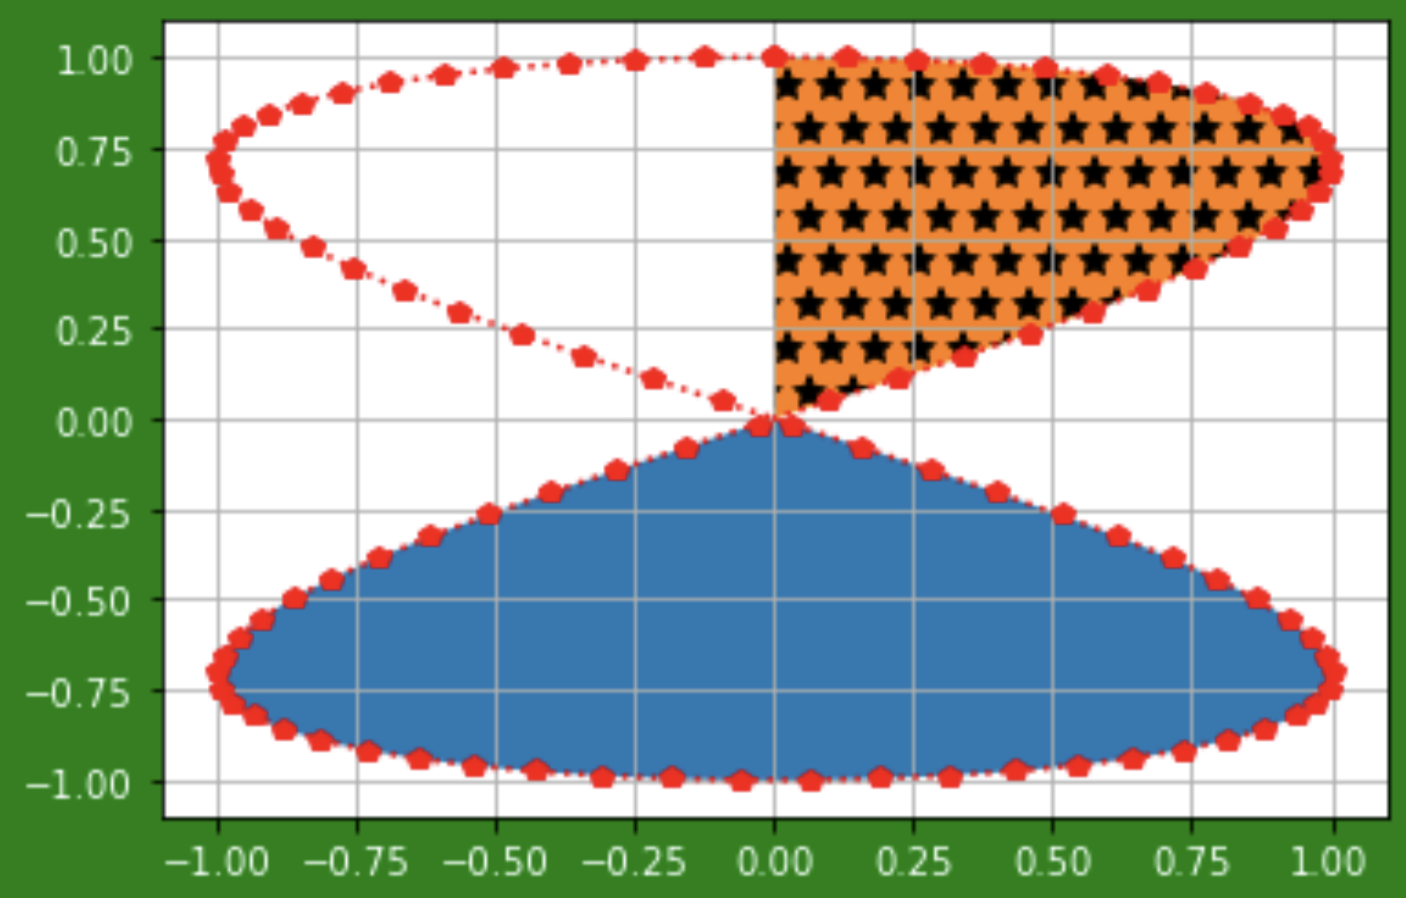

In [1]:
import numpy as np
import matplotlib.pyplot as plt

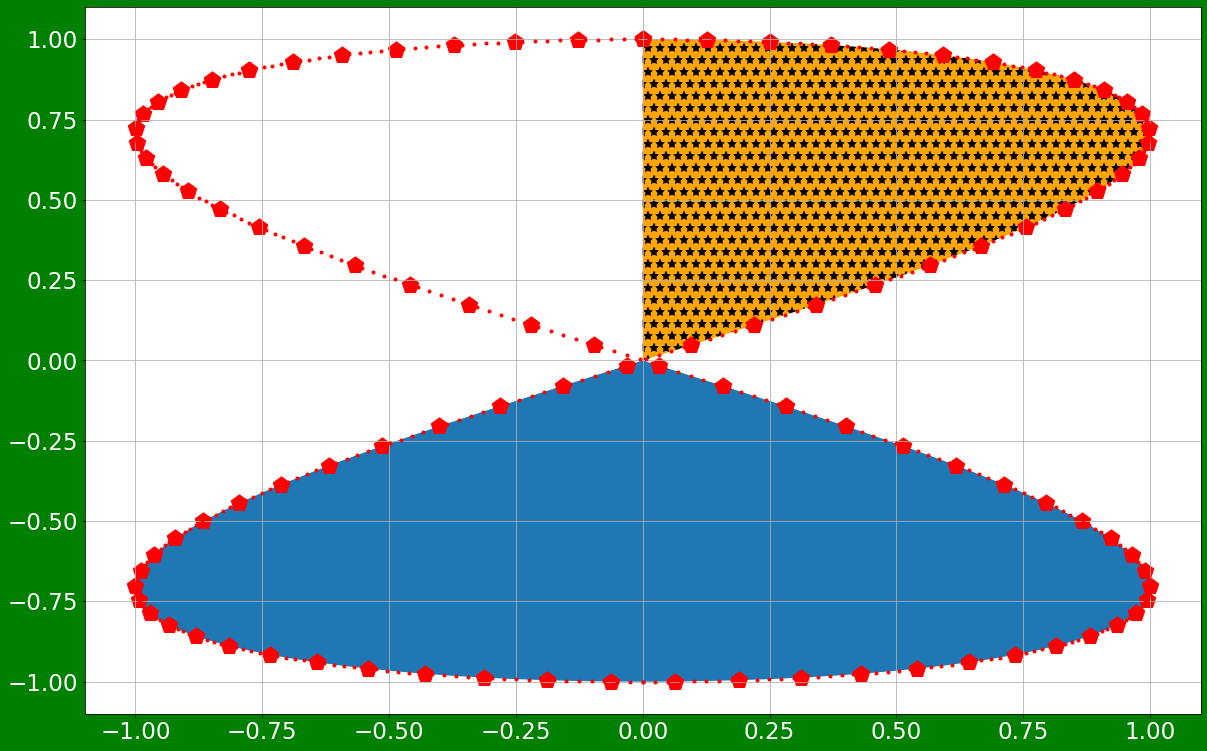

In [32]:
fig = plt.figure(figsize=(20, 13))
fig.patch.set_facecolor('green')
t = np.linspace(-np.pi, np.pi, 500)
t_fill_blue = np.append(np.linspace(-np.pi,-np.pi / 2, 50), np.linspace(np.pi / 2,np.pi,  50))
t_fill_stars = np.linspace(0, np.pi / 2, 50)
plt.fill_between(np.sin(2*t_fill_blue), np.cos(t_fill_blue))
plt.fill_between(np.sin(2*t_fill_stars), np.cos(t_fill_stars), facecolor='orange', hatch='*')
plt.grid()
plt.xticks(fontsize=23, c='white')
plt.yticks(fontsize=23, c='white')
plt.plot(np.sin(2*t), np.cos(1*t), "r.")
points = np.linspace(-2*np.pi, 2*np.pi, 100)
plt.scatter(np.sin(2*points), np.cos(1*points), marker='p', s=300, c='r');

# Задание 2 [3 балла]
#### Напишите функцию, которая осуществляет SQL запросы над pandas-dataframe. Протестируйте ее на предложенном наборе данных

In [36]:
import pandas as pd
import scipy.stats as sps
d1 = {'one': pd.Series(range(6), index=list('abcdef')),
     'two': pd.Series(range(7), index=list('abcdefg')),
     'three': pd.Series(sps.norm.rvs(size=7), index=list('abcdefg'))}
df1 = pd.DataFrame(d1).reset_index()
df1

,index,one,two,three
0,a,0.0,0,1.840463
1,b,1.0,1,-0.755056
2,c,2.0,2,0.129642
3,d,3.0,3,-0.046669
4,e,4.0,4,-0.306947
5,f,5.0,5,1.769500
6,g,NaN,6,0.905202


In [37]:
import pandas as pd
import scipy.stats as sps
d2 = {'second_index': pd.Series(['a', 'b', 'd', 'c', 'd', 'c', 'k', 'l']),
     'four': pd.Series(range(10, 18)),
     'five': pd.Series(sps.norm.rvs(size=8))}
df2 = pd.DataFrame(d2)
df2

,second_index,four,five
0,a,10,1.557490
1,b,11,0.341540
2,d,12,-0.756509
3,c,13,0.536991
4,d,14,-0.265637
5,c,15,0.686361
6,k,16,1.978223
7,l,17,0.620500


### Пример формата запроса:

SELECT tab1.column1 as c1, tab2.column2 as c2, tab1.column1+tab2.column2 as sum12
FROM tab1 RIGHT JOIN tab2 ON tab1.ind1=tab2.ind2
WHERE tab2.four>5 ORDER BY tab2.column3 ASC, tab1.column4 DESC

Реализовать какой-то больший функционал, чем указан в примере запроса не нужно. Общий функционал: новые имена столбцов, арифметические операции на столбцах, объединение таблиц (не только правое!), фильтр по условию, сортировка.

Чтобы легче было парсить, считаем, что пользователь всегда пишет запрос красиво и корректно (как в примере).

In [38]:
query = \
"""
первый тест

SELECT df1.one as c1, df2.five as c2, df1.three+df2.four as sum12
FROM df1 JOIN df2 ON tab1.index=tab2.second_index
WHERE df2.one>=2
ORDER BY df2.five ASC

второй тест (другой джоин и несколько сортировок)

SELECT df1.one as c1, df2.five as c2, df1.three+df2.four as sum12
FROM df1 RIGHT JOIN df2 ON tab1.index=tab2.second_index
WHERE df2.four>=12
ORDER BY df2.five ASC, df1.one DESC

"""


In [39]:
tab_dict = {'df1': df1, 'df2': df2}

In [228]:
def parse(query):
    parsed = {
        'SELECT': dict(), 
        'FROM': {
            'JOIN': 'inner', # default in pandas
            'l': '',
            'r': '',
            'ON': []
        },
        'WHERE': '', # пока с одним условием
        'ORDER_BY': [] # dicts will here {'col': '', 'mode': ''}
    }
    # parsing
    for line in query.split('\n'): # распилили по строкам
        space_idx = line.find(' ') # отделим ключевое слово запроса
        command, attributes = line[:space_idx], line[space_idx + 1:]
        if command == 'SELECT':
            for new_col in attributes.split(','): # делим по запятым
                components = new_col.split() 
                if len(components) == 3: # проверяем, что в формате: ... as new_name
                    parsed['SELECT'][components[-1]] = components[0] 
                else:
                    raise ValueError("Incorrect format")
                    
        elif command == 'FROM':
            join, condition = attributes.split('ON') # разделим на состовляющие джоина
            # 'on' part
            for col in condition.strip().split('='):
                parsed['FROM']['ON'].append(col.split('.')[-1]) # выделяем названия колонок
            # 'join' part
            join = join.split()
            parsed['FROM']['l'] = join[0]
            parsed['FROM']['r'] = join[-1]
            if len(join) > 3: # случай где не обычный джоин
                parsed['FROM']['JOIN'] = join[1].lower()
                
        elif command == 'WHERE':
            parsed['WHERE'] = attributes
        elif command == 'ORDER':
            components = attributes[3:].split(',') # делим по запятым
            for component in components:
                col, mode = component.split()
                parsed['ORDER_BY'].append({'col': col, 'mode': mode})
        else:
            raise ValueError("Unknown command")
    return parsed

In [229]:
def SQL_query(query, tab_dict):
    parsed = parse(query)
    print(parsed)
    # do join
    key_cols = parsed['FROM']['ON'] # по каким колонкам
    l_name, r_name = parsed['FROM']['l'], parsed['FROM']['r']
    df1, df2 = tab_dict[l_name].copy(), tab_dict[r_name].copy() # скопировались от исходных
    # для простоты дальнейшей обработки, переименуем столбцы, как в sql запросе
    df1.rename(columns={col: l_name+'.'+col for col in df1.columns}, inplace=True)
    df2.rename(columns={col: r_name+'.'+col for col in df2.columns}, inplace=True)
    # в pandas merge происзодит по столбцам с одинаковыми названиями, спрваим
    df2.rename(columns={(r_name+'.'+key_cols[-1]): (l_name+'.'+key_cols[0])}, inplace=True)
    df = pd.merge(df1, df2, how=parsed['FROM']['JOIN'], on=(l_name+'.'+key_cols[0])) # смерджили
    # filtering
    condition = parsed['WHERE']
    sign = '' # разбиваем условие на чсти и опознаем знак
    idx = 0
    for sign_ in ['>=', '<=', '=', '>', '<']:
        idx_ = condition.find(sign_)
        if idx_ != -1:
            sign = sign_
            idx = idx_
            break
    col = condition[:idx]
    val = float(condition[idx + len(sign):])
    if sign == '=':
        df = df[df[col] == val]
    elif sign == '>':
        df = df[df[col] > val]
    elif sign == '<':
        df = df[df[col] < val]
    elif sign == '>=':
        df = df[df[col] >= val]
    else:
        df = df[df[col] <= val]
    # sort
    for attr in parsed['ORDER_BY']: # по каждой нужной колонке сортируем
        col, mode = attr['col'], attr['mode']
        df = df.sort_values(by=col, ascending=(True if mode == 'ASC' else False))
    # select
    operations = ['+', '-', '*', '/'] 
    for (new_col, what) in parsed['SELECT'].items():
        # каждую часть разиваем на части, также опознаем операцию
        sign = ''
        idx = 0
        for sign_ in operations:
            idx_ = what.find(sign_)
            if idx_ != -1:
                sign = sign_
                idx = idx_
        if sign == '':
            df[new_col] = df[what]
        else:
            lhs = what[:idx]
            rhs = what[idx + 1:]
            if sign == '+':
                df[new_col] = df[lhs]+df[rhs]
            elif sign == '-':
                df[new_col] = df[lhs]-df[rhs]
            elif sign == '*':
                df[new_col] = df[lhs]*df[rhs]
            else:
                df[new_col] = df[lhs]/df[rhs]
    
    return df[parsed['SELECT'].keys()]
    

In [230]:
query = "SELECT df1.one as c1, df2.five as c2, df1.three+df2.four as sum12\nFROM df1 JOIN df2 ON tab1.index=tab2.second_index\nWHERE df1.one>=2\nORDER BY df2.five ASC"

In [231]:
SQL_query(query, tab_dict)

{'SELECT': {'c1': 'df1.one', 'c2': 'df2.five', 'sum12': 'df1.three+df2.four'}, 'FROM': {'JOIN': 'inner', 'l': 'df1', 'r': 'df2', 'ON': ['index', 'second_index']}, 'WHERE': 'df1.one>=2', 'ORDER_BY': [{'col': 'df2.five', 'mode': 'ASC'}]}


,c1,c2,sum12
4,3.0,-0.756509,11.953331
5,3.0,-0.265637,13.953331
2,2.0,0.536991,13.129642
3,2.0,0.686361,15.129642


In [232]:
query = 'SELECT df1.one as c1, df2.five as c2, df1.three+df2.four as sum12\nFROM df1 RIGHT JOIN df2 ON tab1.index=tab2.second_index\nWHERE df2.four>=12\nORDER BY df2.five ASC, df1.one DESC'

In [233]:
SQL_query(query, tab_dict)

{'SELECT': {'c1': 'df1.one', 'c2': 'df2.five', 'sum12': 'df1.three+df2.four'}, 'FROM': {'JOIN': 'right', 'l': 'df1', 'r': 'df2', 'ON': ['index', 'second_index']}, 'WHERE': 'df2.four>=12', 'ORDER_BY': [{'col': 'df2.five', 'mode': 'ASC'}, {'col': 'df1.one', 'mode': 'DESC'}]}


,c1,c2,sum12
2,3.0,-0.756509,11.953331
4,3.0,-0.265637,13.953331
3,2.0,0.536991,13.129642
5,2.0,0.686361,15.129642
7,NaN,0.620500,NaN
6,NaN,1.978223,NaN


# Задание 3 [5 баллов] 
#### Творческое задание 
Вам дан набор данных (HW2.csv) с различной информацией о клиентах банка. Мы хотим выдвинуть гипотезы о сигналах, которые говорят, что клиент может уйти из нашего банка. Флаг ухода (таргет, целевая переменная) - переменная Attrition_Flag.

Необходимо провести исследовательский анализ данных и изучить взаимосвязь между целевой переменной и всеми остальными средствами Pandas и Seaborn [NumPy и Matplotlib могут идти как вспомогательные] (всякий ML сюда прикручивать не надо - на оценку это не повлияет), а также сами переменные.

Здесь очень сильно будет оцениваться описательная часть (что и зачем вы сделали и что увидели) и какие выводы получили по результатам анализа, а также масштаб использования функций Pandas и Seaborn.

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<b>загрузим данные<b>

In [46]:
data = pd.read_csv('HW2.csv')

In [47]:
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


<b>посмотрим какие данные вообще<b>

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

<b>Посмотрим на распределение категориальных признаков, сгруппированных по таргету</b>

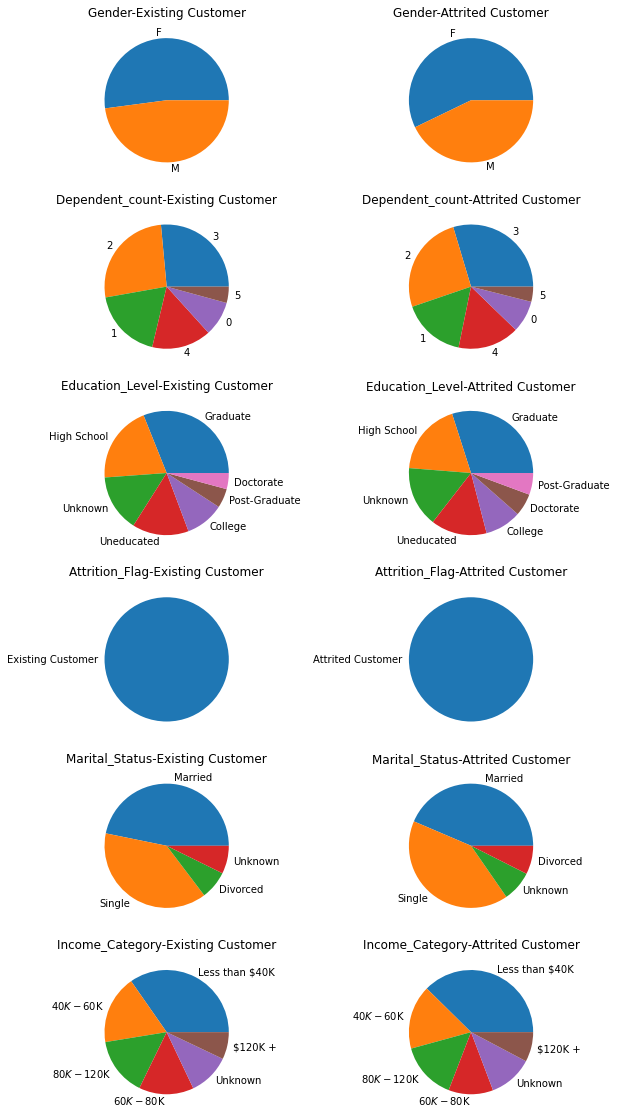

In [141]:
fig, ax = plt.subplots(6, 2, figsize=(10, 20))
groups = ['Existing Customer', 'Attrited Customer']
cols = ['Gender', 'Dependent_count', 'Education_Level', 'Attrition_Flag', 'Marital_Status', 'Income_Category']
for i in range(6):
    stats = data.groupby('Attrition_Flag')[cols[i]].value_counts()
    for j in range(2):
        ax[i][j].set_title(cols[i]+'-'+groups[j])
        ax[i][j].pie(stats[groups[j]], labels=stats[groups[j]].index);


<b>Эти распределения вышли очень похожими, поэтому какие-то выводу по этому сделать сложно. Рассмотрим числовые признаки<b>

In [53]:
data.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.159997,0.840003
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.365301,0.365301
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000008,0.000420
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000099,0.999660
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000181,0.999820
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000337,0.999900
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,0.999580,0.999990


<b>Тоже мало полезной информации. Попробуем статистический подход

<b>Закодируем с помощью label encoding'а категориальные признаки и посмотрим на корриляционную таблицу

In [59]:
from sklearn.preprocessing import LabelEncoder

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [64]:
new_data = data.copy() # скопировали, чтобы не испортить исходные
new_data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [65]:
for col in ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']:
    encoder = LabelEncoder()
    new_data[col] = encoder.fit_transform(data[col])
new_data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,1,45,1,3,3,1,2,0,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,1,49,0,5,2,2,4,0,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,1,51,1,3,2,1,3,0,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,1,40,0,4,3,3,4,0,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,1,40,1,3,5,1,2,0,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


<b>Построим корреляционную таблицу, рассмотрим столбец с тагретом, чтобы понять какие признаки с ним коррелируют

<b>чем ближе по модулю к 1, тем сильнее корреляция => отсортируем

In [71]:
data_corr = new_data.corr()
data_corr['Attrition_Flag'].apply(lambda x: abs(x)).sort_values()

Avg_Open_To_Buy                                                                                                                       0.000285
Education_Level                                                                                                                       0.005551
Card_Category                                                                                                                         0.006038
Months_on_book                                                                                                                        0.013687
Income_Category                                                                                                                       0.017584
Customer_Age                                                                                                                          0.018203
Marital_Status                                                                                                                        0.018597

<b>составим список претендентов на важные признаки, где коэффициент корреляции по модулю больше 0.1 (очевидно, что таргет сам с собой коррелирует)

<b>Последние 2 столбца не будем брать, так это результат работы какого-то классификатора, который очень даже хорошо классифицирует, ведь поэффициент сравним с 1

In [215]:
pretendents = [
    'Total_Relationship_Count',
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon',
    'Total_Revolving_Bal',
    'Total_Trans_Amt',
    'Total_Trans_Ct',
    'Total_Ct_Chng_Q4_Q1',
    'Avg_Utilization_Ratio'
]

<b>Заметим, что в этот список не попали категориальные признаки, значит для всех них рассмотрим среднее значение, для положительного и отрицательного класса, в попытке найти зависимости

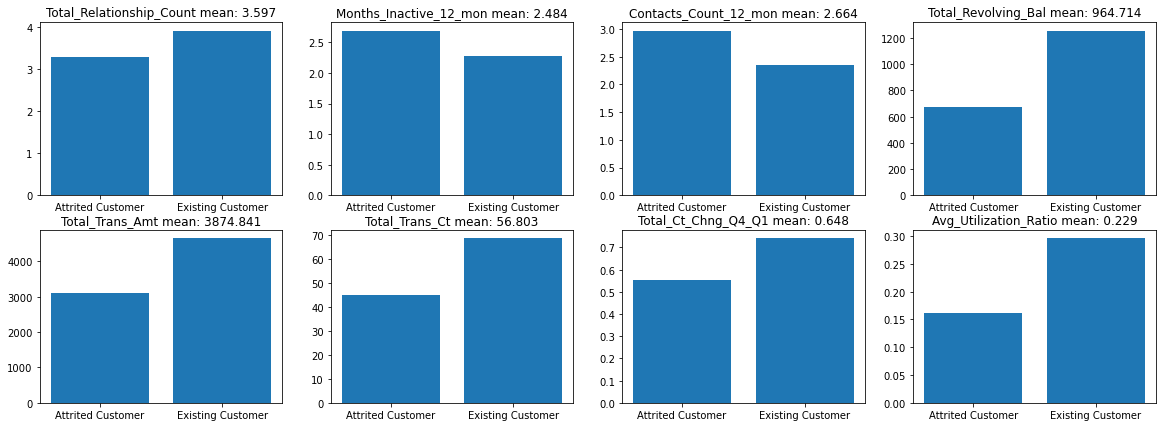

In [217]:
fig, axes = plt.subplots(2, 4, figsize=(20, 7))
for i, ax in enumerate(axes.flatten()):
    info = data.groupby('Attrition_Flag')
    attr = info[pretendents[i]].mean()['Attrited Customer']
    exist = info[pretendents[i]].mean()['Existing Customer']
    mean = info[pretendents[i]].mean().mean()
    ax.bar(['Attrited Customer', 'Existing Customer'], [attr, exist])
    ax.set_title(pretendents[i] +' mean: '+str(np.round(mean, 3)))
    # mean в заголовке значит среднее между средними


<b>Теперь графики несут побольше информации, сразу можно выделить 3 признака, подходящих на роль интересующих нас (где разность средних не мала): 'Total_Revolving_Bal', 'Total_Trans_Amt', 'Total_Trans_Ct'

<b>Запишем условие (наша лампочка), говорящее, что клиент собирается уйти. То есть где признак меньше среднего из заголовка соответствующего графика

In [218]:
condition = (data['Total_Revolving_Bal'] < 964.714) & (data['Total_Trans_Amt'] < 3874.841) & (data['Total_Trans_Ct'] < 56.803)

In [219]:
attr_clients = data[condition.values]
attr_clients['Attrition_Flag'].value_counts()

Attrited Customer    913
Existing Customer    536
Name: Attrition_Flag, dtype: int64

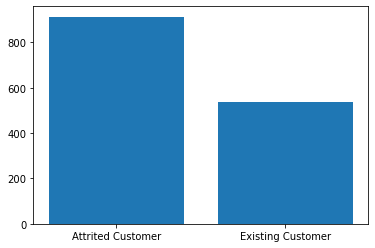

In [220]:
stats = attr_clients['Attrition_Flag'].value_counts()
plt.bar(stats.index, stats);

In [221]:
exist_clients = data[list(map(lambda x: not x, condition.values))]
exist_clients['Attrition_Flag'].value_counts()

Existing Customer    7964
Attrited Customer     714
Name: Attrition_Flag, dtype: int64

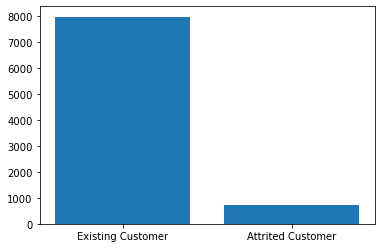

In [222]:
stats = exist_clients['Attrition_Flag'].value_counts()
plt.bar(stats.index, stats);

<b>Посчитаем accuracy

In [223]:
(913 + 7964) / (913 + 536 + 7964 + 714)

0.876567591586847

<b>Неплохой результат. Попробуем посчитать f1-score

In [227]:
print('     |true|false\ntrue |913 | 536\nfalse|714 |7964')

     |true|false
true |913 | 536
false|714 |7964


In [224]:
precision = 913 / (913 + 536)
precision

0.6300897170462388

In [225]:
recall = 913 / (913 + 714)
recall

0.5611555009219422

In [226]:
f1 = 2*precision*recall / (precision+recall)
f1

0.5936280884265279

<b>Тут уже f1 не сильно радует, но и это было ожидаемо из последних двух графиков. Видно, что условие хорошо отличает existed от attrited, однако далеко не все действительно attrited, из тех, что модель посчитала 